# Analysis of Denver Crime Data

DATA LINK : https://www.kaggle.com/paultimothymooney/denver-crime-data 

The data we took is crime data of Denver.  The reasons of the crime, traffic crimes, place, time of the crime is recorded in the dataset.  
The dataset includes criminal offenses in the City and County of Denver for the previous five calendar years plus the current year to date. The data is based on the National Incident Based Reporting System (NIBRS) which includes all victims of person crimes and all crimes within an incident.

-> QUESTIONS TO BE ANALYZED?

1) What regularities or patterns are important to the city?

2) Of these patterns, which are most important and which are least important?

3) What descriptions, explanations, understandings, predictions, does the city need regarding this data set?

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
import cufflinks as cf
import plotly.tools as tls
import chart_studio.plotly as py
import folium
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline
sns.set()
p = sns.cubehelix_palette(15)
p2 = sns.cubehelix_palette(10)
p3 = sns.cubehelix_palette(24)
p4 = sns.cubehelix_palette(5)

Connected to MongoDB using python, pymongo and imported the data into a pandas dataframe.


In [ ]:
import pymongo as pym
from pymongo import MongoClient as MC
client = MC()
db = client['denver']
crime = db.crimes
df = pd.DataFrame(list(crime.find()))

In [ ]:
df = pd.read_csv("crime.csv")

In [ ]:
df.head()

In [ ]:
pd.set_option('display.max_columns', None)
df.info()

## Process Date and Clean Data

In [ ]:
df.FIRST_OCCURRENCE_DATE = pd.to_datetime(df.FIRST_OCCURRENCE_DATE)
df["YEAR"] = df.FIRST_OCCURRENCE_DATE.dt.year
df["DAY"] = df.FIRST_OCCURRENCE_DATE.dt.day
df["DAY_OF_WEEK"] = df.FIRST_OCCURRENCE_DATE.dt.dayofweek
df["MONTH"] = df.FIRST_OCCURRENCE_DATE.dt.month
df["HOUR"] = df.FIRST_OCCURRENCE_DATE.dt.hour
df.index = pd.DatetimeIndex(df["FIRST_OCCURRENCE_DATE"])

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
print("This dataset ranges from {} to {}".format(df.index.min(), df.index.max()))

In [ ]:
# The last month's data is incomplete, so let's get rid of it
date_before = pd.Timestamp(2019, 7, 1)
df = df[df.FIRST_OCCURRENCE_DATE < date_before]

## Spark Contribution
Imported the data into a spark-dataframe using pyspark for better operationality and analysis.

In [ ]:
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
myspark = SparkSession \
    .builder \
    .master("local")\
    .appName("myApp") \
    .config("spark.sql.warehouse.dir", "hdfs://MA:8020/user/hive/warehouse")\
    .enableHiveSupport()\
    .getOrCreate()

In [ ]:
mySchema = StructType([ StructField("DISTRICT_ID", LongType(), True)\
                       ,StructField("FIRST_OCCURRENCE_DATE", StringType(), True)\
                       ,StructField("GEO_LAT", FloatType(), True)\
                       ,StructField("GEO_LON", FloatType(), True)\
                       ,StructField("GEO_X", FloatType(), True)\
                       ,StructField("GEO_Y", FloatType(), True)\
                       ,StructField("INCIDENT_ADDRESS", StringType(), True)\
                       ,StructField("INCIDENT_ID", LongType(), True)\
                       ,StructField("IS_CRIME", IntegerType(), True)\
                       ,StructField("IS_TRAFFIC", IntegerType(), True)\
                       ,StructField("LAST_OCCURRENCE_DATE", StringType(), True)\
                       ,StructField("NEIGHBORHOOD_ID", StringType(), True)\
                       ,StructField("OFFENSE_CATEGORY_ID", StringType(), True)\
                       ,StructField("OFFENSE_CODE", IntegerType(), True)\
                       ,StructField("OFFENSE_CODE_EXTENSION", IntegerType(), True)\
                       ,StructField("OFFENSE_ID", LongType(), True)\
                       ,StructField("OFFENSE_TYPE_ID", StringType(), True)\
                       ,StructField("PRECINCT_ID", IntegerType(), True)\
                       ,StructField("REPORTED_DATE", StringType(), True)\
                       ,StructField("_id", StringType(), True)\
                       ,StructField("YEAR", IntegerType(), True)\
                       ,StructField("DAY", IntegerType(), True)\
                       ,StructField("DAY_OF_WEEK", IntegerType(), True)\
                       ,StructField("MONTH", IntegerType(), True)\
                       ,StructField("HOUR", IntegerType(), True)])

Created spark dataframe

In [ ]:
sp_df = myspark.createDataFrame(df, schema=mySchema)

In [ ]:
sp_df.createOrReplaceTempView("crimes")

In [ ]:
myspark.sql("select INCIDENT_ID from crimes").show()

# Analysis of each of the attributes and their Trends using basic Exploratory Techniques 

## Crime vs Traffic Accidents


Used Hive to query the data

In [ ]:
s1 = myspark.sql("select IS_CRIME, IS_TRAFFIC from crimes")
df1 = s1.toPandas()

In [ ]:
df1

In [ ]:
plt.figure(figsize=(6,5))
crime_and_traffic = pd.crosstab(index=df1['IS_CRIME'],
                                columns=df1['IS_TRAFFIC'])
crime_and_traffic.index = ["not crime", "crime"]
crime_and_traffic.columns = ["not traffic", "traffic"]
sns.heatmap(crime_and_traffic, annot=True, fmt="d", cmap=p2)

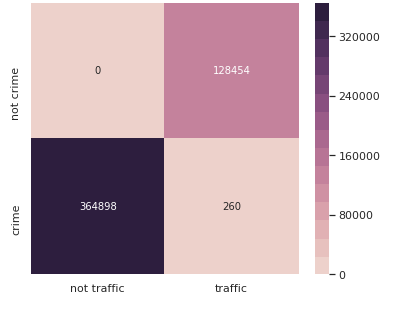

## Offense categories distribution
   

In [ ]:
s2 = myspark.sql("select OFFENSE_CATEGORY_ID from crimes")
df2 = s2.toPandas()

In [ ]:
plt.figure(figsize=(8,8))
cat_freq = df2.OFFENSE_CATEGORY_ID.value_counts()
sns.countplot(y="OFFENSE_CATEGORY_ID", data=df2, order=cat_freq.index, palette=p)

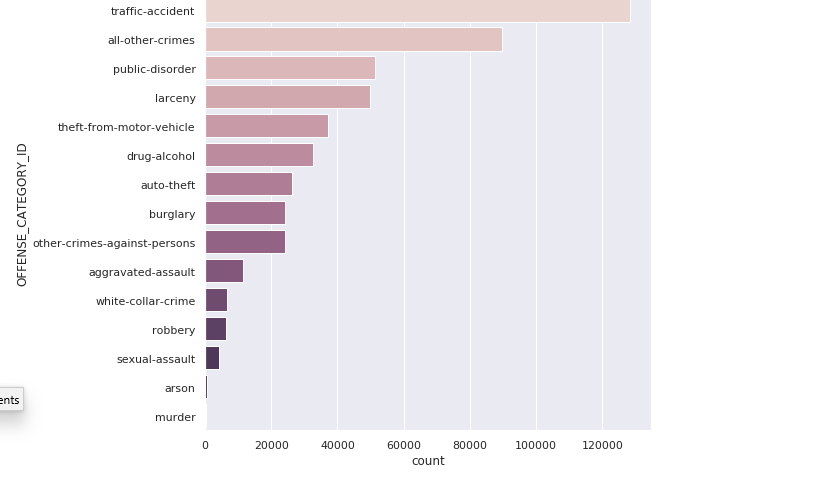

# OBSERVATIONS
> - Excluding traffic accidents the most common category is public disorder
> - Then comes larceny (theft of personal items)
> - We might need to do more analysis with all-other-crimes
> - Murder is very rare in this dataset

## Most and least common offense types excluding traffic accidents

In [ ]:
s3 = myspark.sql("select OFFENSE_TYPE_ID from crimes")
df3 = s3.toPandas()
f, axes = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
plt.subplots_adjust(wspace=.7)
type_freq = df3.OFFENSE_TYPE_ID.value_counts()
common_types = type_freq.iloc[1:11]
rare_types = type_freq.iloc[-10:]
axes[0].set_title("Most common offense types")
sns.countplot(y="OFFENSE_TYPE_ID", data=df3, order=common_types.index, palette=p2, ax=axes[0])
axes[1].set_title("Least common offense types")
sns.countplot(y="OFFENSE_TYPE_ID", data=df3, order=rare_types.index, palette=p2, ax=axes[1])

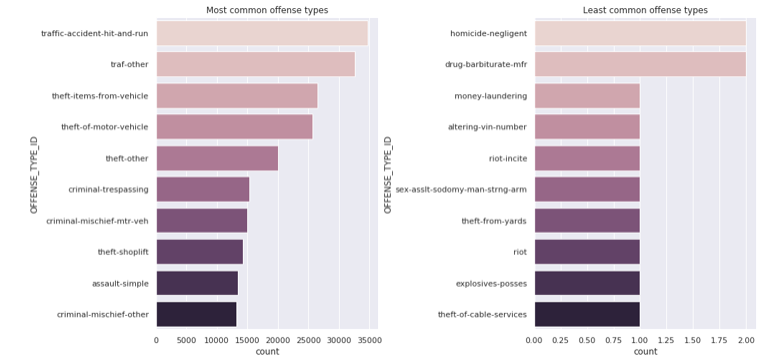

# OBSERVATIONS:
> - A large number of offenses are vehicle-related
> - Public disorder is a common category but riots are actually rare (rare enough it's actually a riot instead of riots)
> - Can't believe theft of cable services is a thing :D

## All other crimes

In [ ]:
s4 = myspark.sql("select OFFENSE_TYPE_ID, OFFENSE_CATEGORY_ID from crimes")
df4 = s4.toPandas()
other_crimes = df4[df4.OFFENSE_CATEGORY_ID == "all-other-crimes"]
other_crimes_freq = other_crimes.OFFENSE_TYPE_ID.value_counts()
f, axes = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
plt.subplots_adjust(wspace=.7)
other_common_types = other_crimes_freq.iloc[1:11]
other_rare_types = other_crimes_freq.iloc[-10:]
f.suptitle("All other crimes", fontsize=32)
axes[0].set_title("Most common offenses")
sns.countplot(y="OFFENSE_TYPE_ID", data=other_crimes, order=other_common_types.index, palette=p2, ax=axes[0])
axes[1].set_title("Least common offenses")
sns.countplot(y="OFFENSE_TYPE_ID", data=other_crimes, order=other_rare_types.index, palette=p2, ax=axes[1])

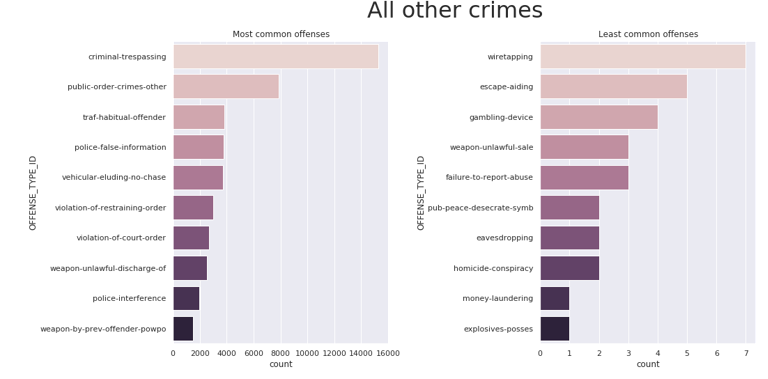


## Distribution of crime vs traffic over months

In [ ]:
s5 = myspark.sql("select HOUR, MONTH, IS_TRAFFIC, IS_CRIME from crimes")
df5 = s5.toPandas()
crimes_df = df5[df5.IS_CRIME==1]
traffic_df = df5[df5.IS_TRAFFIC==1]

In [ ]:
f, axes = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(13)
plt.subplots_adjust(wspace=.5)
axes[0].set_title("Crime")
sns.countplot(x="MONTH", data=crimes_df, palette=p, ax=axes[0])
axes[1].set_title("Traffic Accidents")
sns.countplot(x="MONTH", data=traffic_df, palette=p, ax=axes[1])

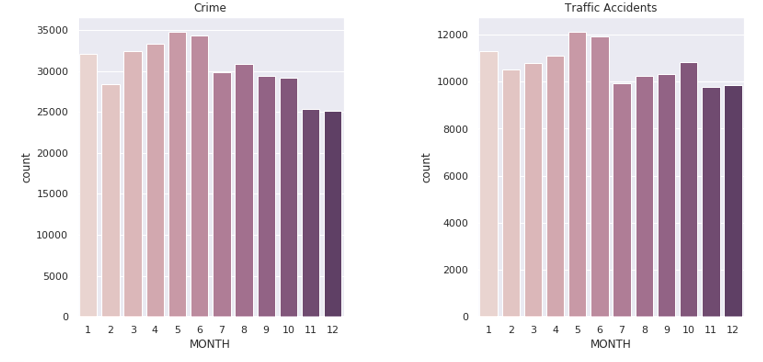

## Distribution of crime vs traffic per hour

In [ ]:
sns.countplot(x="HOUR", data=crimes_df, palette=p3)

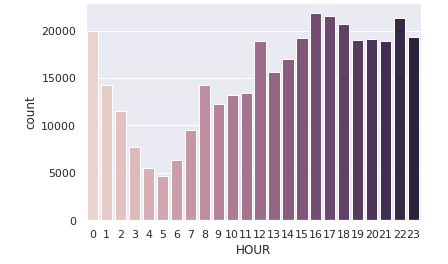

## Overall trend for crimes in Denver

In [ ]:
# mean and standard deviation of crimes per day
crimes_per_day = pd.DataFrame(crimes_df.resample('D').size())
crimes_per_day["MEAN"] = crimes_df.resample('D').size().mean()
crimes_per_day["STD"] = crimes_df.resample('D').size().std()
# upper control limit and lower control limit
UCL = crimes_per_day['MEAN'] + 3 * crimes_per_day['STD']
LCL = crimes_per_day['MEAN'] - 3 * crimes_per_day['STD']

In [ ]:
plt.figure(figsize=(15,6))
df.resample('D').size().plot(label='Crimes per day', color='purple')
UCL.plot(color='red', ls='--', linewidth=1.5, label='UCL')
LCL.plot(color='red', ls='--', linewidth=1.5, label='LCL')
crimes_per_day['MEAN'].plot(color='red', linewidth=2, label='Average')
plt.title('Overall trend of crimes in Denver', fontsize=16)
plt.xlabel('Day')
plt.ylabel('Number of crimes')
plt.tick_params(labelsize=14)

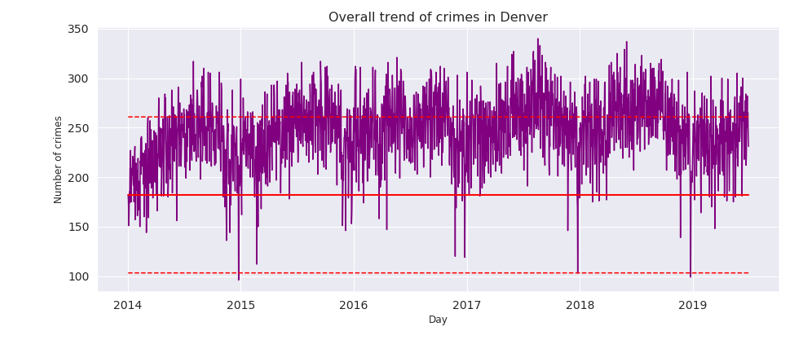

In [ ]:
month_df = crimes_df.resample('M').size()
plt.figure(figsize=(15,6))
month_df.plot(label='Total,  accidents per month, color='purple')
month_df.rolling(window=12).mean().plot(color='red', linewidth=5, label='12-Months Average')
plt.title('Overall trend of crimes in Denver(by month)', fontsize=16)

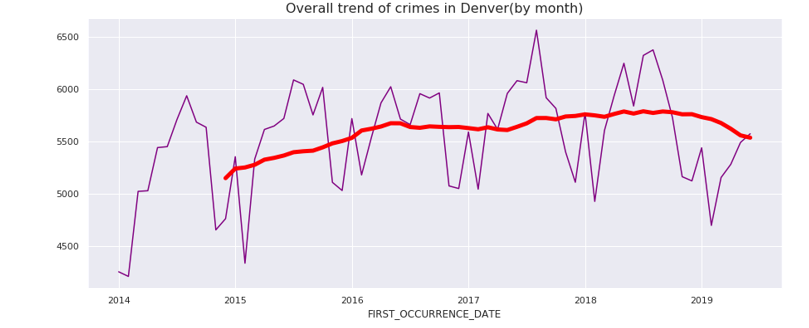

In [ ]:
print("Best Month {0}: {1}".format(month_df.idxmin(), month_df[month_df.idxmin()]))
print("Worst Month {0}: {1}".format(month_df.idxmax(), month_df[month_df.idxmax()]))

# OBSERVATIONS:
> - The overall trend seems to be increasing, and there's a slightly decrease in 2019.
> - But 2019 is not over and the violent month is not here yet.
> - We have more outliers toward the upper end (very violent days).
> - Feburary 2014 is the best month with 4211 crimes.
> - August 2017 was the worst month with 6562 crimes.